In [70]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

In [71]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [72]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [73]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [141]:
runs = [304125,302263,304508]

with open('good_data_WINDOW10.pickle', 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 10

1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


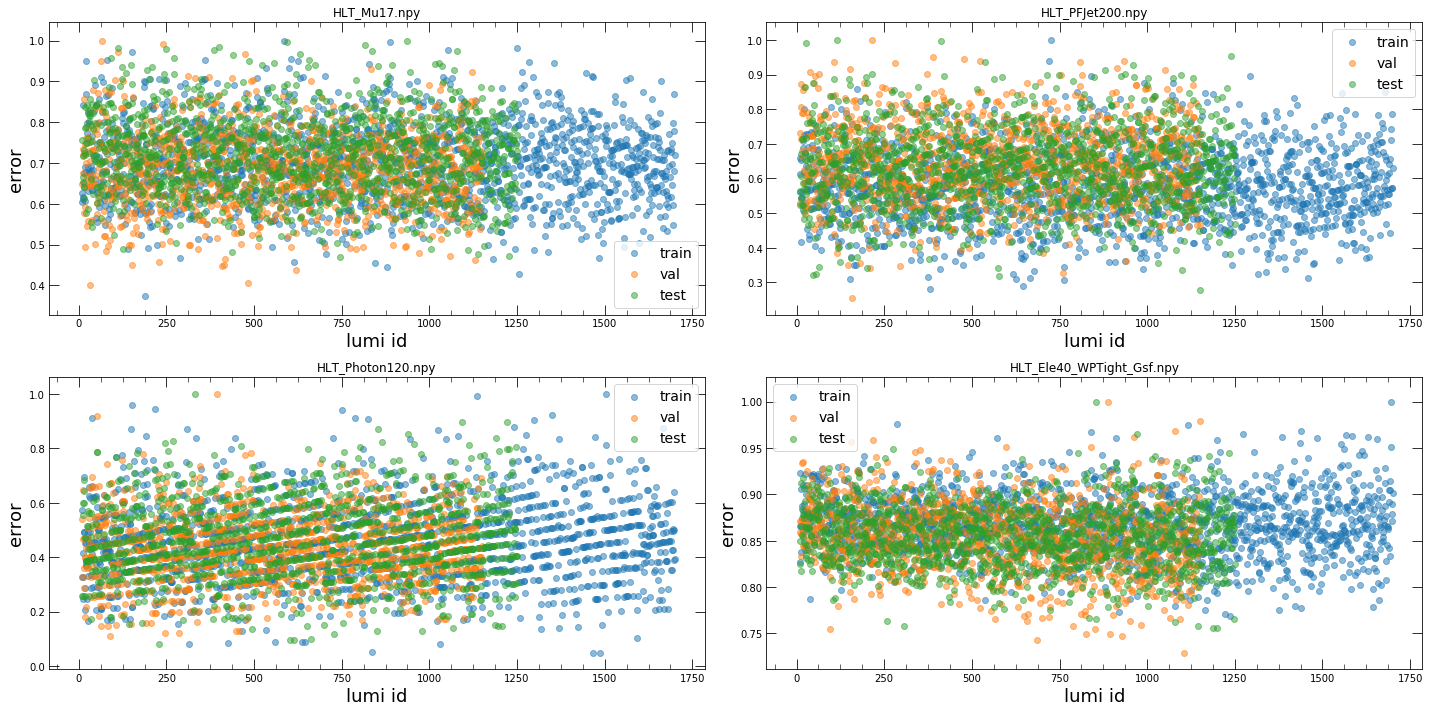

In [142]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [76]:
model_name = "simplest_10"

In [77]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40)                0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 123       
_________________________________________________________________
reconstructed (Dense)        (None, 40)                160       
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


Train on 1660 samples, validate on 1120 samples
Epoch 1/1000
 - 0s - loss: 5978.7765 - val_loss: 5898.2030
Epoch 2/1000
 - 0s - loss: 5835.3309 - val_loss: 5756.0140
Epoch 3/1000
 - 0s - loss: 5694.4693 - val_loss: 5618.6958
Epoch 4/1000
 - 0s - loss: 5559.1174 - val_loss: 5483.5014
Epoch 5/1000
 - 0s - loss: 5424.7617 - val_loss: 5350.0412
Epoch 6/1000
 - 0s - loss: 5292.6281 - val_loss: 5219.1612
Epoch 7/1000
 - 0s - loss: 5162.9663 - val_loss: 5090.9886
Epoch 8/1000
 - 0s - loss: 5036.2386 - val_loss: 4965.4802
Epoch 9/1000
 - 0s - loss: 4912.0299 - val_loss: 4843.3831
Epoch 10/1000
 - 0s - loss: 4791.2317 - val_loss: 4723.5959
Epoch 11/1000
 - 0s - loss: 4672.7725 - val_loss: 4607.3481
Epoch 12/1000
 - 0s - loss: 4557.7017 - val_loss: 4493.3545
Epoch 13/1000
 - 0s - loss: 4444.9578 - val_loss: 4382.8856
Epoch 14/1000
 - 0s - loss: 4335.7352 - val_loss: 4274.6163
Epoch 15/1000
 - 0s - loss: 4228.6883 - val_loss: 4169.7900
Epoch 16/1000
 - 0s - loss: 4124.7619 - val_loss: 4067.1319
E

Epoch 139/1000
 - 0s - loss: 373.8085 - val_loss: 371.5525
Epoch 140/1000
 - 0s - loss: 368.2523 - val_loss: 366.0427
Epoch 141/1000
 - 0s - loss: 362.7959 - val_loss: 360.6383
Epoch 142/1000
 - 0s - loss: 357.4440 - val_loss: 355.3332
Epoch 143/1000
 - 0s - loss: 352.1900 - val_loss: 350.1249
Epoch 144/1000
 - 0s - loss: 347.0315 - val_loss: 345.0116
Epoch 145/1000
 - 0s - loss: 341.9666 - val_loss: 339.9911
Epoch 146/1000
 - 0s - loss: 336.9927 - val_loss: 335.0615
Epoch 147/1000
 - 0s - loss: 332.1112 - val_loss: 330.2170
Epoch 148/1000
 - 0s - loss: 327.3095 - val_loss: 325.4597
Epoch 149/1000
 - 0s - loss: 322.5991 - val_loss: 320.7868
Epoch 150/1000
 - 0s - loss: 317.9720 - val_loss: 316.2008
Epoch 151/1000
 - 0s - loss: 313.4287 - val_loss: 311.6965
Epoch 152/1000
 - 0s - loss: 308.9650 - val_loss: 307.2721
Epoch 153/1000
 - 0s - loss: 304.5835 - val_loss: 302.9224
Epoch 154/1000
 - 0s - loss: 300.2738 - val_loss: 298.6524
Epoch 155/1000
 - 0s - loss: 296.0457 - val_loss: 294.45

Epoch 280/1000
 - 0s - loss: 68.1928 - val_loss: 68.0619
Epoch 281/1000
 - 0s - loss: 67.5244 - val_loss: 67.3958
Epoch 282/1000
 - 0s - loss: 66.8641 - val_loss: 66.7377
Epoch 283/1000
 - 0s - loss: 66.2117 - val_loss: 66.0878
Epoch 284/1000
 - 0s - loss: 65.5671 - val_loss: 65.4458
Epoch 285/1000
 - 0s - loss: 64.9303 - val_loss: 64.8116
Epoch 286/1000
 - 0s - loss: 64.3012 - val_loss: 64.1847
Epoch 287/1000
 - 0s - loss: 63.6796 - val_loss: 63.5654
Epoch 288/1000
 - 0s - loss: 63.0653 - val_loss: 62.9536
Epoch 289/1000
 - 0s - loss: 62.4588 - val_loss: 62.3489
Epoch 290/1000
 - 0s - loss: 61.8592 - val_loss: 61.7515
Epoch 291/1000
 - 0s - loss: 61.2667 - val_loss: 61.1611
Epoch 292/1000
 - 0s - loss: 60.6813 - val_loss: 60.5777
Epoch 293/1000
 - 0s - loss: 60.1027 - val_loss: 60.0012
Epoch 294/1000
 - 0s - loss: 59.5309 - val_loss: 59.4313
Epoch 295/1000
 - 0s - loss: 58.9653 - val_loss: 58.8683
Epoch 296/1000
 - 0s - loss: 58.4070 - val_loss: 58.3118
Epoch 297/1000
 - 0s - loss: 57

Epoch 424/1000
 - 0s - loss: 19.9721 - val_loss: 19.9714
Epoch 425/1000
 - 0s - loss: 19.8237 - val_loss: 19.8232
Epoch 426/1000
 - 0s - loss: 19.6765 - val_loss: 19.6763
Epoch 427/1000
 - 0s - loss: 19.5307 - val_loss: 19.5307
Epoch 428/1000
 - 0s - loss: 19.3863 - val_loss: 19.3864
Epoch 429/1000
 - 0s - loss: 19.2431 - val_loss: 19.2434
Epoch 430/1000
 - 0s - loss: 19.1013 - val_loss: 19.1016
Epoch 431/1000
 - 0s - loss: 18.9606 - val_loss: 18.9612
Epoch 432/1000
 - 0s - loss: 18.8212 - val_loss: 18.8219
Epoch 433/1000
 - 0s - loss: 18.6830 - val_loss: 18.6839
Epoch 434/1000
 - 0s - loss: 18.5461 - val_loss: 18.5472
Epoch 435/1000
 - 0s - loss: 18.4105 - val_loss: 18.4116
Epoch 436/1000
 - 0s - loss: 18.2757 - val_loss: 18.2772
Epoch 437/1000
 - 0s - loss: 18.1424 - val_loss: 18.1440
Epoch 438/1000
 - 0s - loss: 18.0104 - val_loss: 18.0120
Epoch 439/1000
 - 0s - loss: 17.8794 - val_loss: 17.8811
Epoch 440/1000
 - 0s - loss: 17.7493 - val_loss: 17.7514
Epoch 441/1000
 - 0s - loss: 17

Epoch 570/1000
 - 0s - loss: 7.4464 - val_loss: 7.4532
Epoch 571/1000
 - 0s - loss: 7.4005 - val_loss: 7.4074
Epoch 572/1000
 - 0s - loss: 7.3551 - val_loss: 7.3619
Epoch 573/1000
 - 0s - loss: 7.3100 - val_loss: 7.3168
Epoch 574/1000
 - 0s - loss: 7.2652 - val_loss: 7.2720
Epoch 575/1000
 - 0s - loss: 7.2207 - val_loss: 7.2275
Epoch 576/1000
 - 0s - loss: 7.1765 - val_loss: 7.1833
Epoch 577/1000
 - 0s - loss: 7.1326 - val_loss: 7.1394
Epoch 578/1000
 - 0s - loss: 7.0891 - val_loss: 7.0958
Epoch 579/1000
 - 0s - loss: 7.0459 - val_loss: 7.0526
Epoch 580/1000
 - 0s - loss: 7.0029 - val_loss: 7.0097
Epoch 581/1000
 - 0s - loss: 6.9603 - val_loss: 6.9670
Epoch 582/1000
 - 0s - loss: 6.9180 - val_loss: 6.9247
Epoch 583/1000
 - 0s - loss: 6.8760 - val_loss: 6.8827
Epoch 584/1000
 - 0s - loss: 6.8343 - val_loss: 6.8410
Epoch 585/1000
 - 0s - loss: 6.7929 - val_loss: 6.7995
Epoch 586/1000
 - 0s - loss: 6.7517 - val_loss: 6.7584
Epoch 587/1000
 - 0s - loss: 6.7109 - val_loss: 6.7175
Epoch 588/

Epoch 719/1000
 - 0s - loss: 3.1576 - val_loss: 3.1619
Epoch 720/1000
 - 0s - loss: 3.1406 - val_loss: 3.1448
Epoch 721/1000
 - 0s - loss: 3.1236 - val_loss: 3.1279
Epoch 722/1000
 - 0s - loss: 3.1068 - val_loss: 3.1110
Epoch 723/1000
 - 0s - loss: 3.0901 - val_loss: 3.0943
Epoch 724/1000
 - 0s - loss: 3.0735 - val_loss: 3.0776
Epoch 725/1000
 - 0s - loss: 3.0570 - val_loss: 3.0611
Epoch 726/1000
 - 0s - loss: 3.0406 - val_loss: 3.0447
Epoch 727/1000
 - 0s - loss: 3.0242 - val_loss: 3.0284
Epoch 728/1000
 - 0s - loss: 3.0080 - val_loss: 3.0121
Epoch 729/1000
 - 0s - loss: 2.9919 - val_loss: 2.9960
Epoch 730/1000
 - 0s - loss: 2.9759 - val_loss: 2.9799
Epoch 731/1000
 - 0s - loss: 2.9600 - val_loss: 2.9640
Epoch 732/1000
 - 0s - loss: 2.9441 - val_loss: 2.9482
Epoch 733/1000
 - 0s - loss: 2.9284 - val_loss: 2.9324
Epoch 734/1000
 - 0s - loss: 2.9128 - val_loss: 2.9168
Epoch 735/1000
 - 0s - loss: 2.8972 - val_loss: 2.9012
Epoch 736/1000
 - 0s - loss: 2.8818 - val_loss: 2.8857
Epoch 737/

Epoch 868/1000
 - 0s - loss: 1.4633 - val_loss: 1.4653
Epoch 869/1000
 - 0s - loss: 1.4561 - val_loss: 1.4581
Epoch 870/1000
 - 0s - loss: 1.4489 - val_loss: 1.4509
Epoch 871/1000
 - 0s - loss: 1.4418 - val_loss: 1.4437
Epoch 872/1000
 - 0s - loss: 1.4347 - val_loss: 1.4366
Epoch 873/1000
 - 0s - loss: 1.4276 - val_loss: 1.4295
Epoch 874/1000
 - 0s - loss: 1.4206 - val_loss: 1.4225
Epoch 875/1000
 - 0s - loss: 1.4136 - val_loss: 1.4155
Epoch 876/1000
 - 0s - loss: 1.4066 - val_loss: 1.4085
Epoch 877/1000
 - 0s - loss: 1.3997 - val_loss: 1.4016
Epoch 878/1000
 - 0s - loss: 1.3928 - val_loss: 1.3947
Epoch 879/1000
 - 0s - loss: 1.3860 - val_loss: 1.3878
Epoch 880/1000
 - 0s - loss: 1.3792 - val_loss: 1.3810
Epoch 881/1000
 - 0s - loss: 1.3724 - val_loss: 1.3742
Epoch 882/1000
 - 0s - loss: 1.3656 - val_loss: 1.3675
Epoch 883/1000
 - 0s - loss: 1.3589 - val_loss: 1.3608
Epoch 884/1000
 - 0s - loss: 1.3523 - val_loss: 1.3541
Epoch 885/1000
 - 0s - loss: 1.3457 - val_loss: 1.3474
Epoch 886/

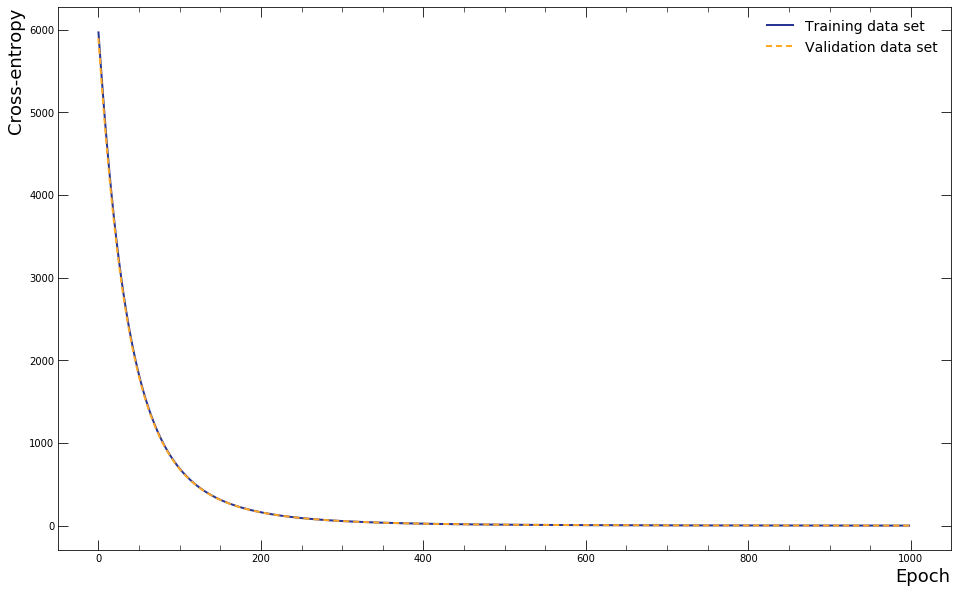

In [78]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

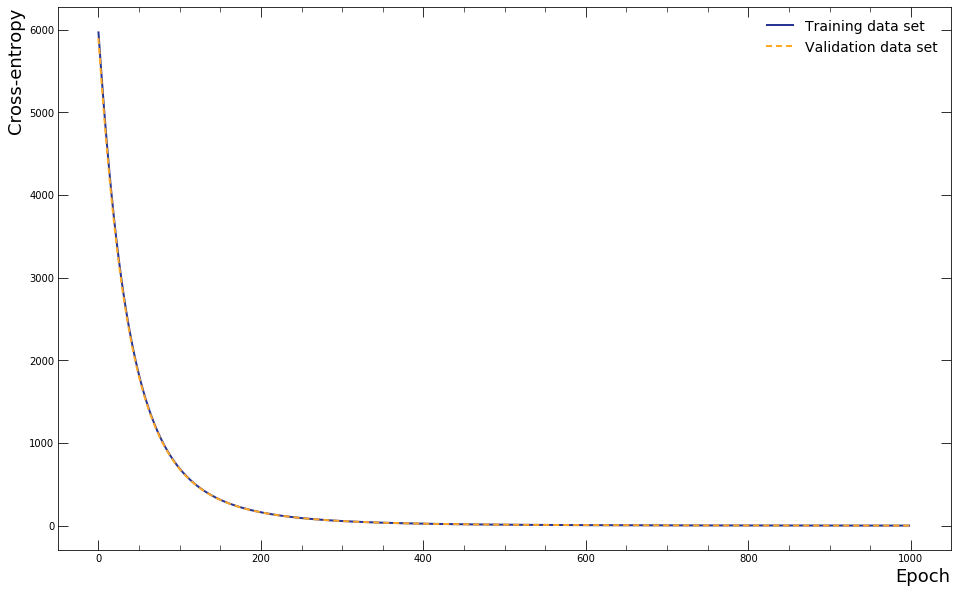

In [79]:
plot_loss(history)

## Training Data

In [174]:
# Generate predictions

model = load_model("%s.h5" % (model_name))
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [175]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train[i][WINDOW*j])

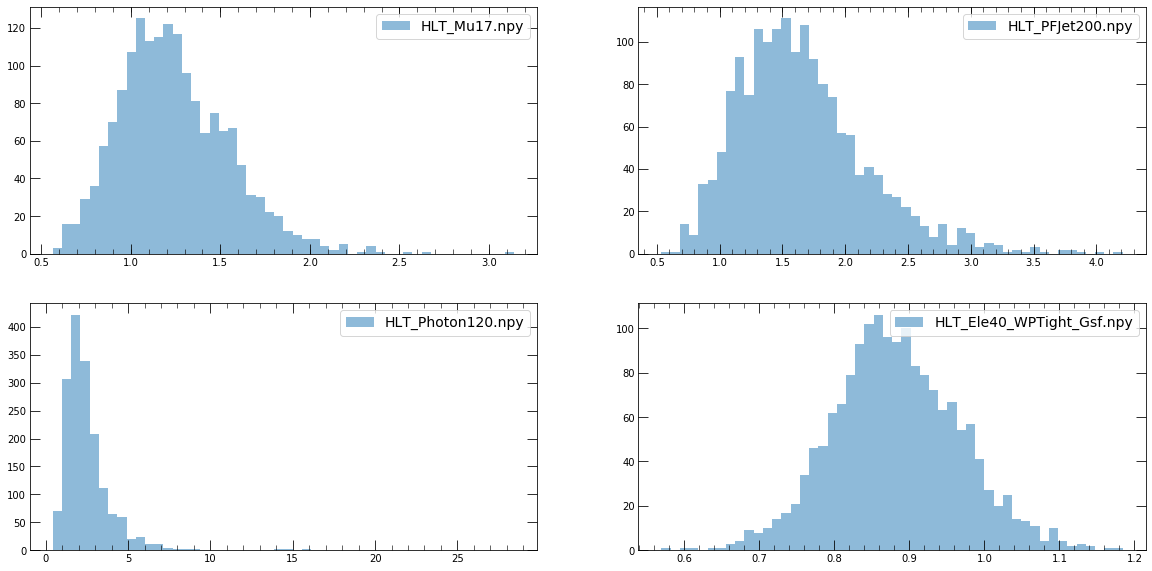

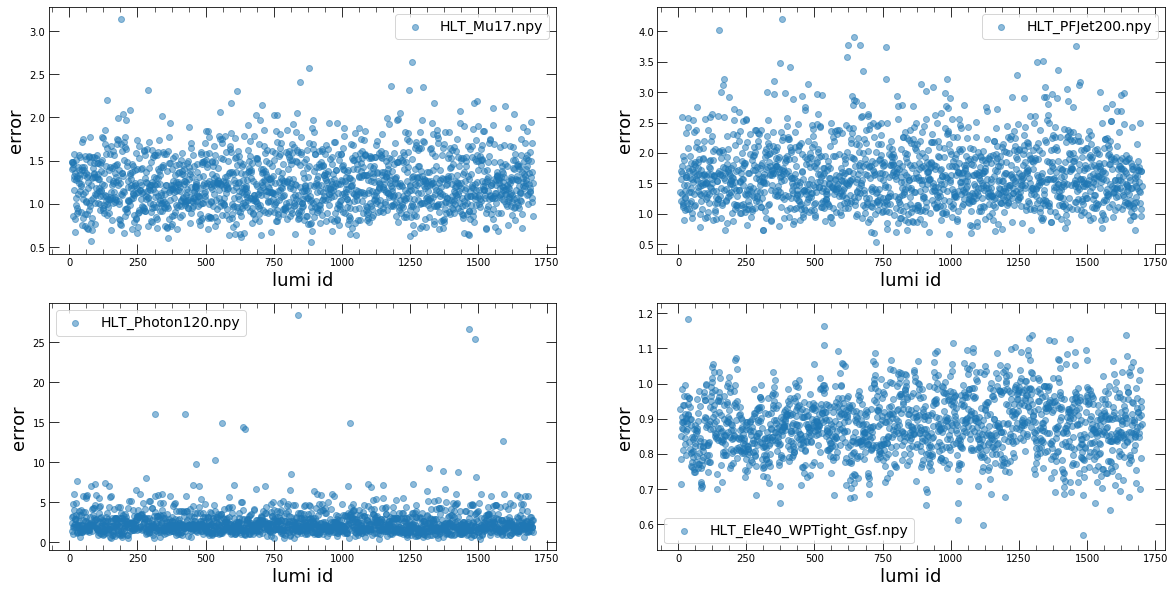

In [177]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[0])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

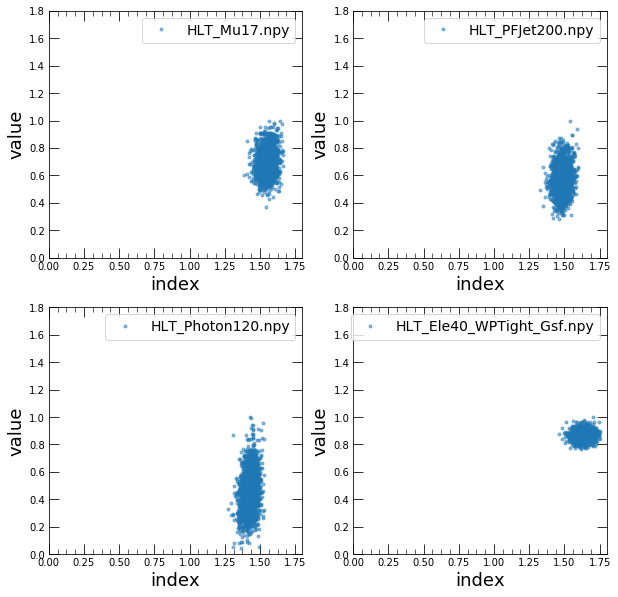

In [178]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,1.8)
    plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [143]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [144]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

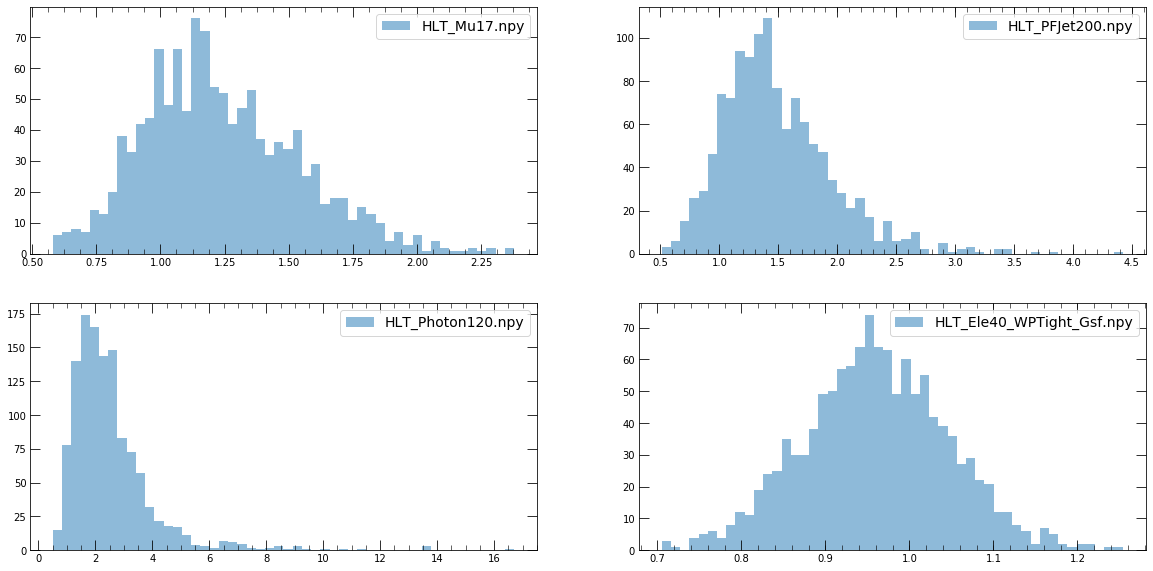

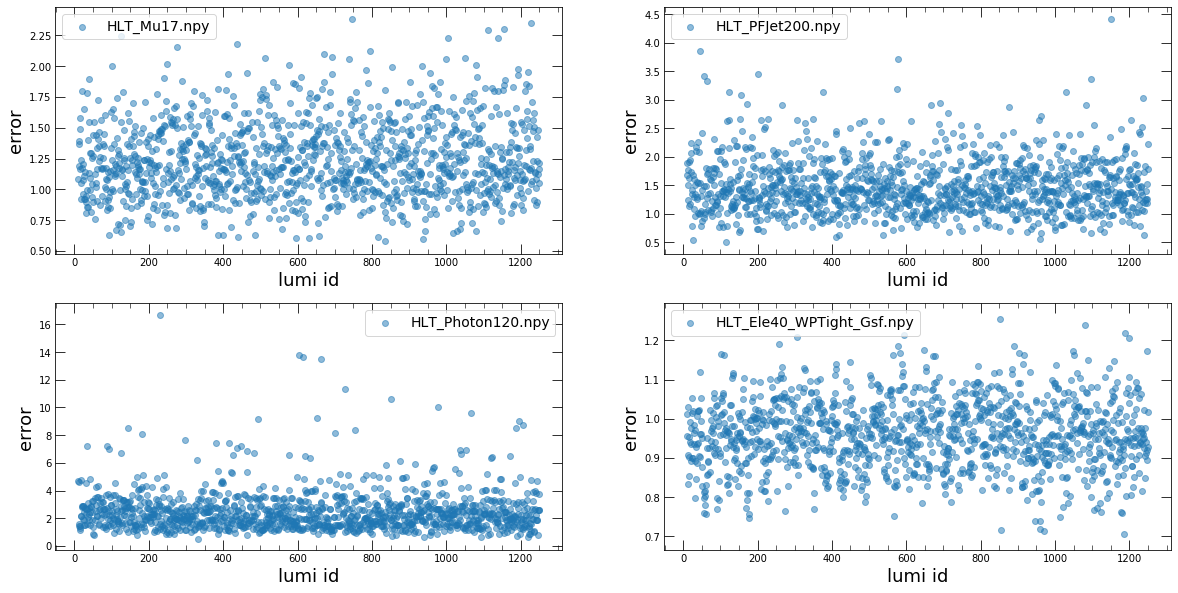

In [145]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

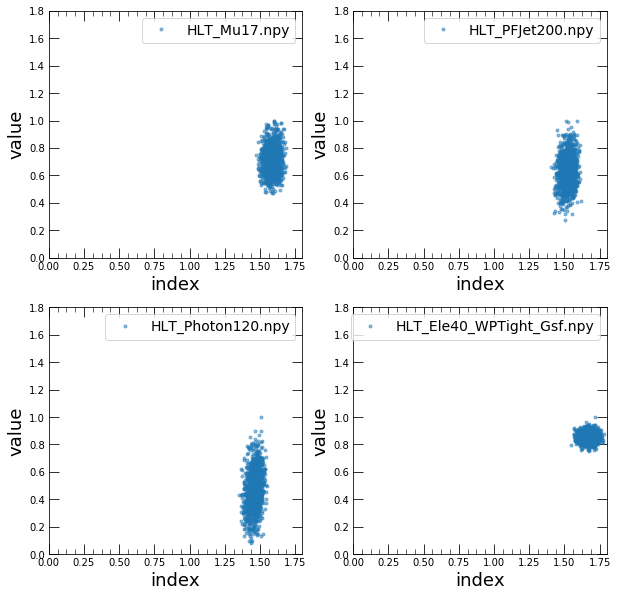

In [146]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,1.8)
    plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [147]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [148]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [149]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [150]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [151]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


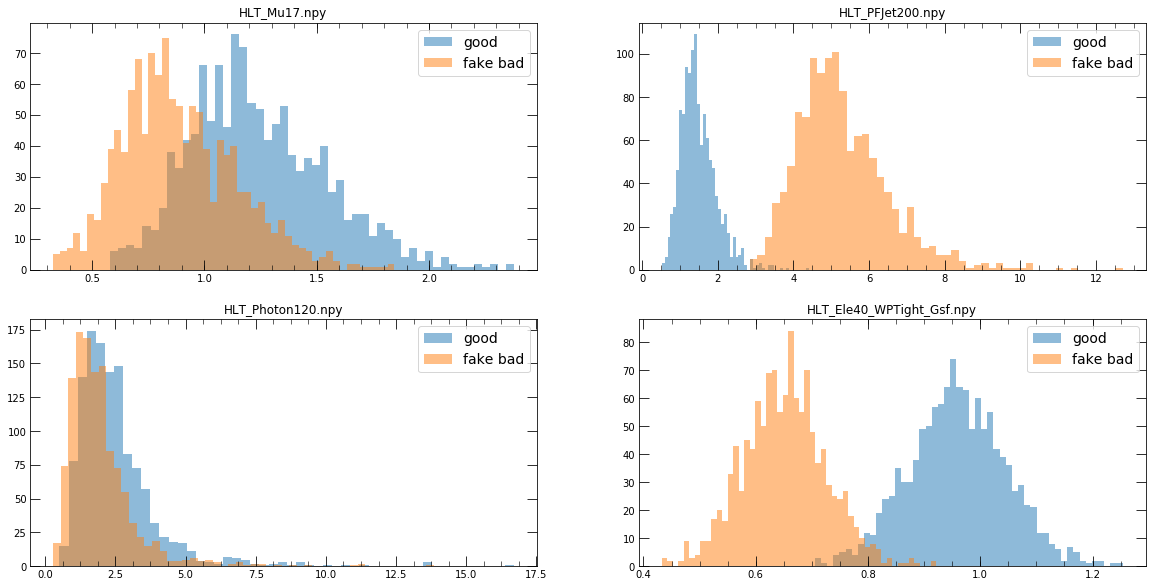

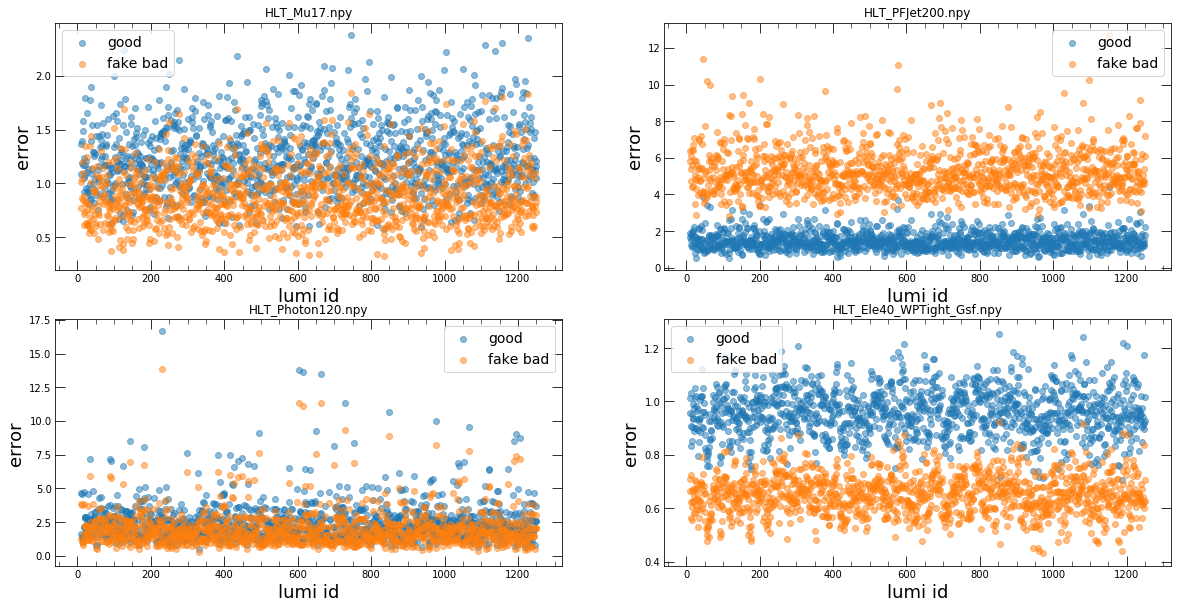

In [152]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

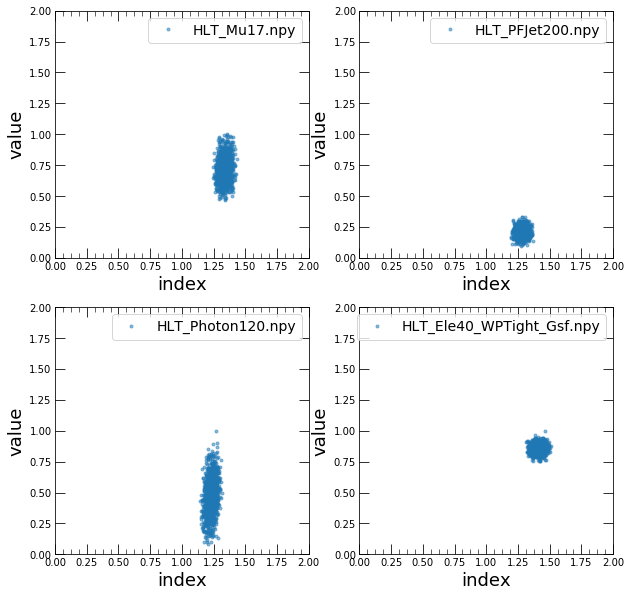

In [153]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,2)
    plt.ylim(0,2)
    plt.legend()    

plt.show()

In [154]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [155]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [156]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [157]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [158]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


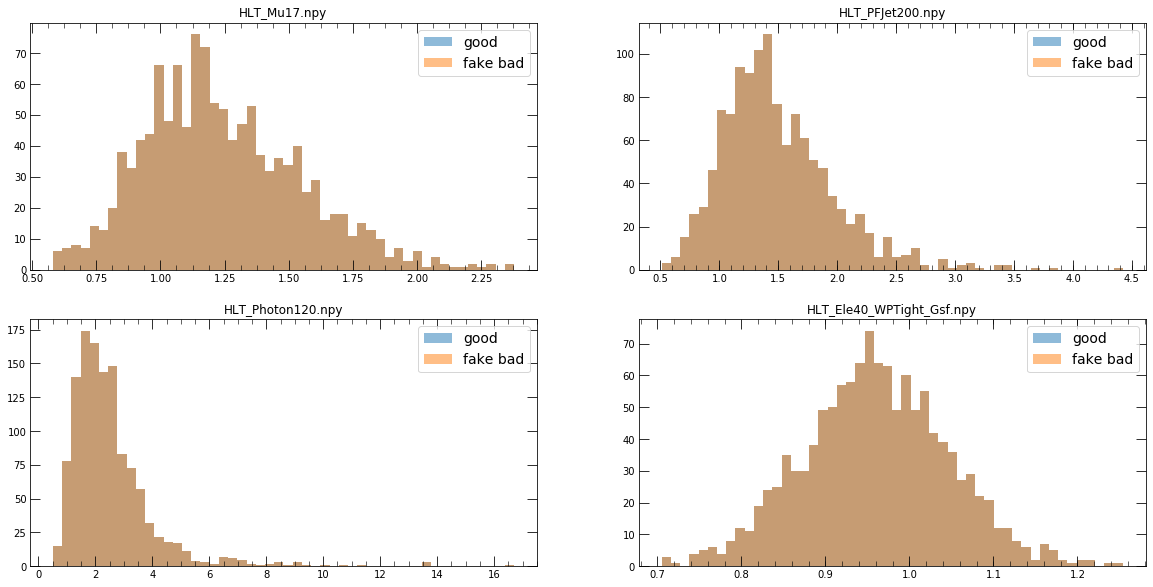

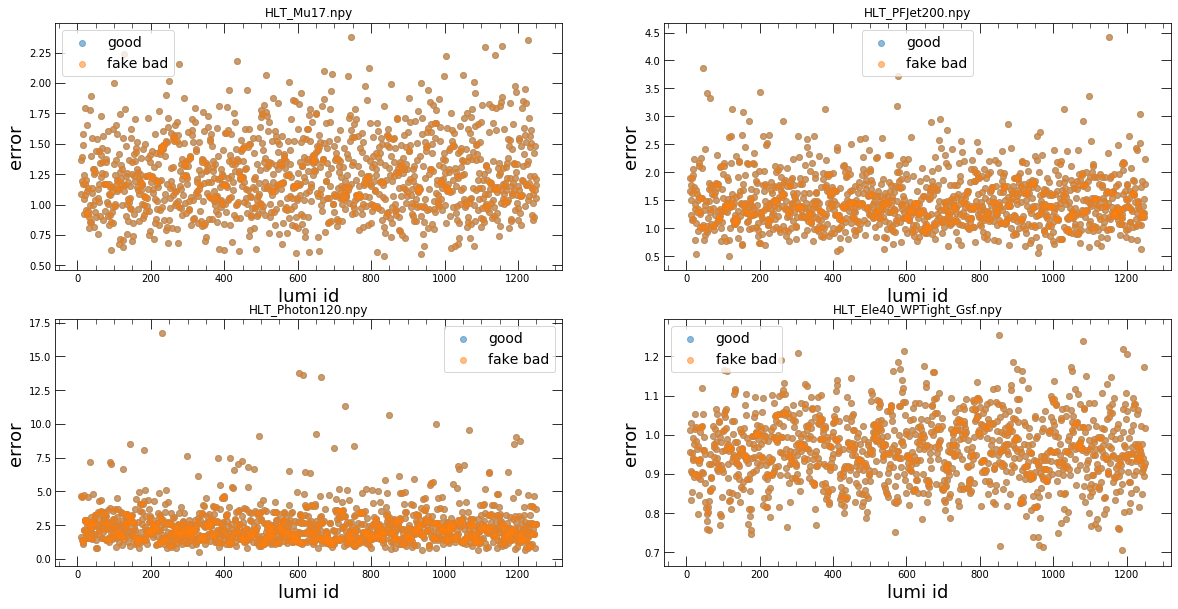

In [159]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

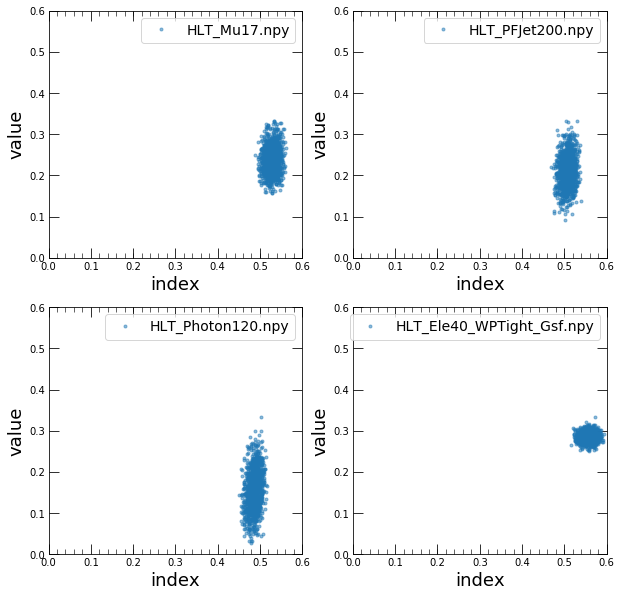

In [160]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,.6)
    plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [161]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [162]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [163]:
bad_runs = [301480]

with open('bad_data_WINDOW10.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [167]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [168]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


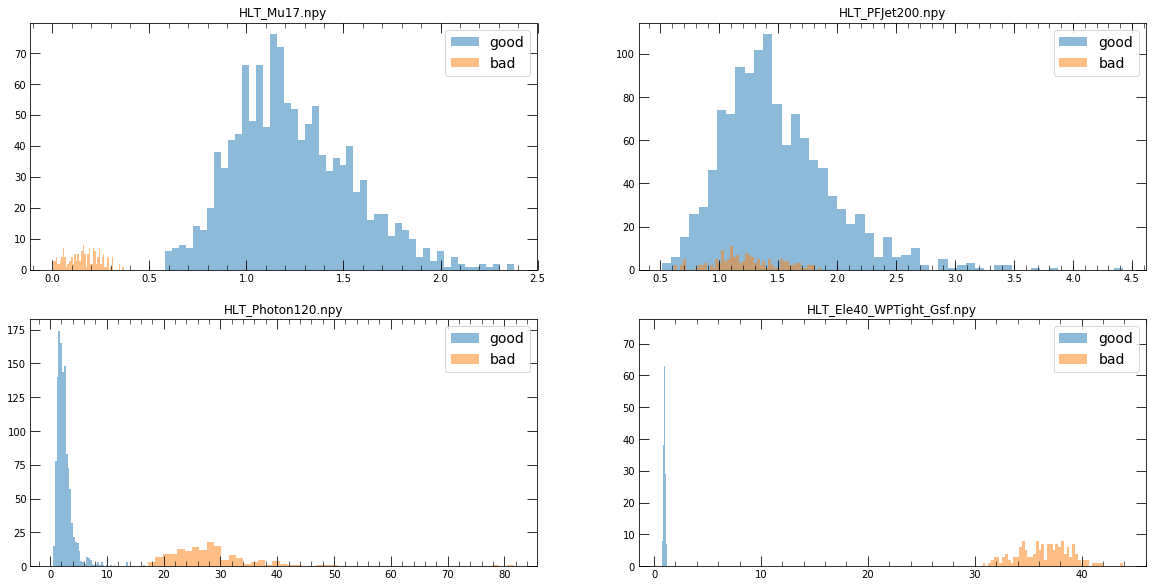

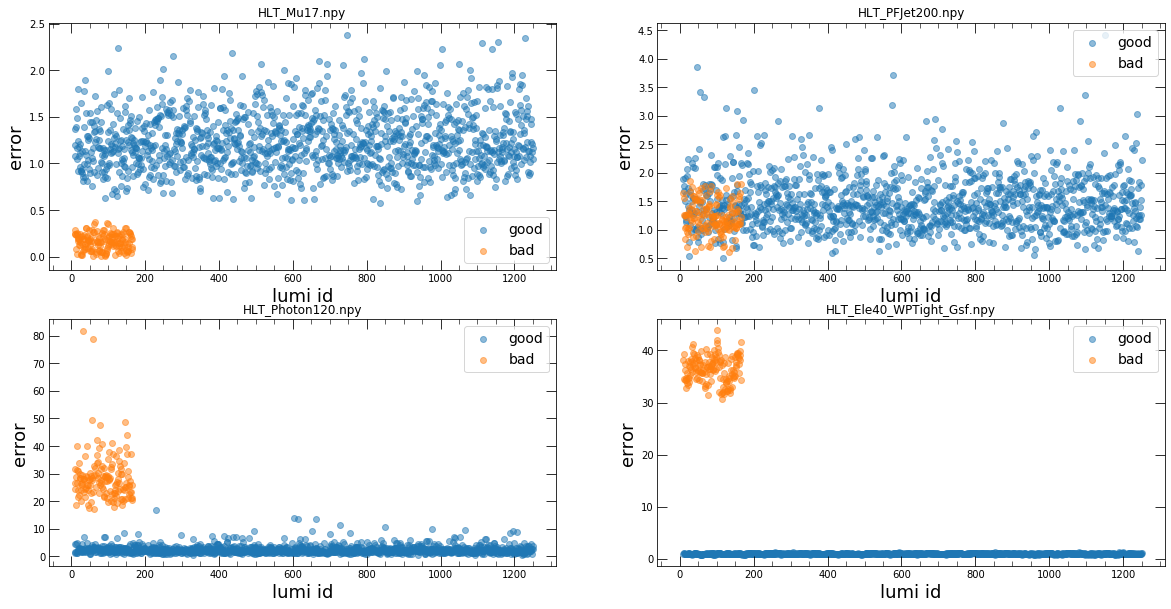

In [169]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

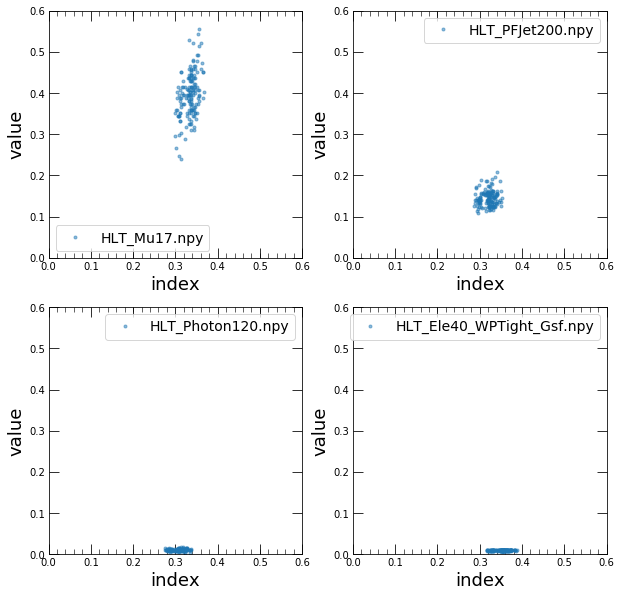

In [173]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,.6)
    plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [179]:
bad_runs = [305588]

with open('bad_data_WINDOW10.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [180]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [181]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


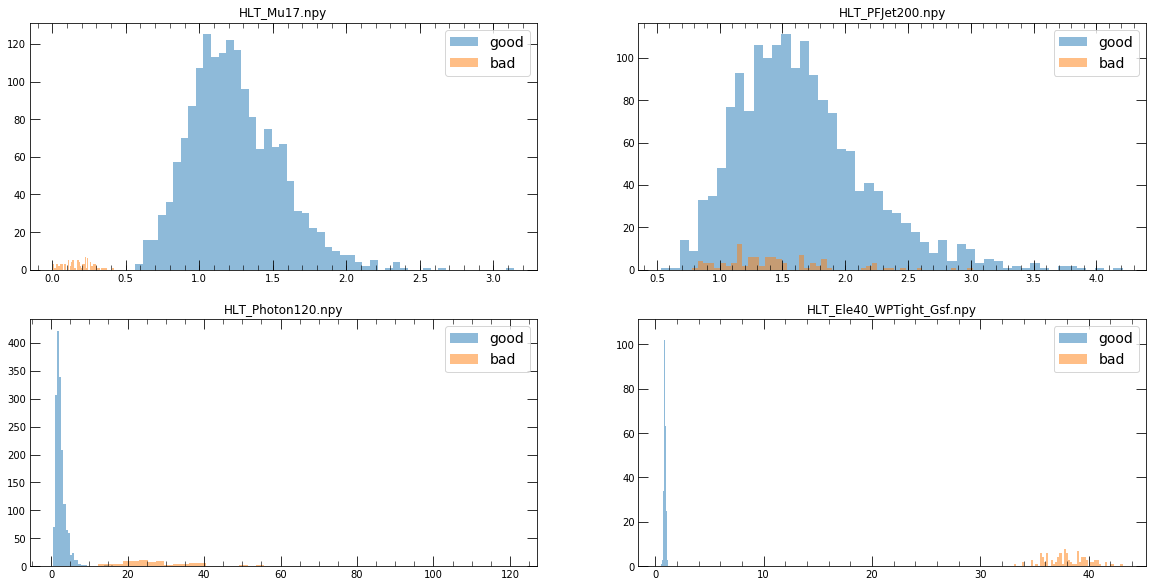

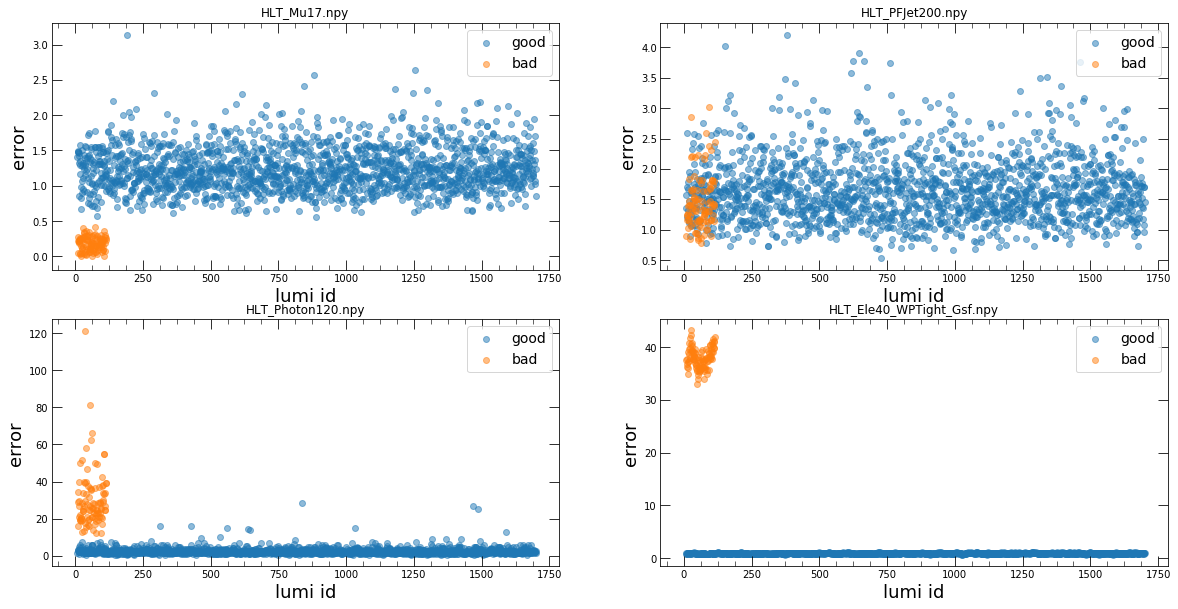

In [182]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

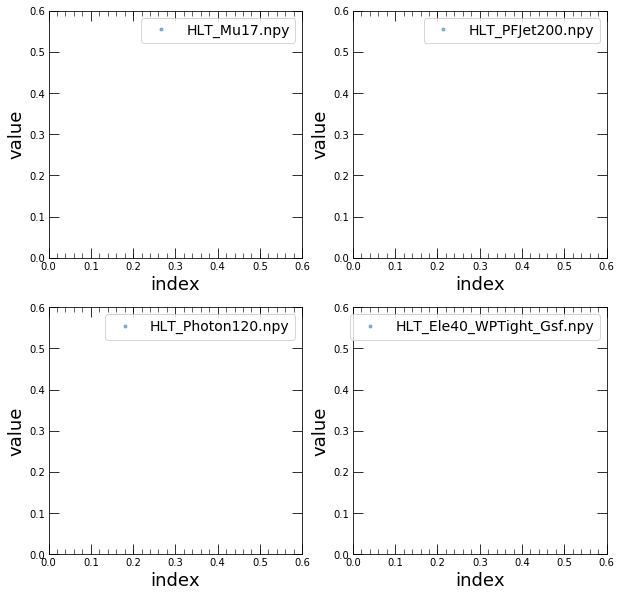

In [183]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    plt.xlim(0,.6)
    plt.ylim(0,.6)
    plt.legend()    

plt.show()